In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


file_path = 'parkinsons/parkinsons.data.csv'
data = pd.read_csv(file_path)


X = data.drop(columns=['status', 'name'])  
y = data['status']  

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [5]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KSVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)  # Default k=5
}

model_results = {}

Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 33, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 186}

Random Forest Model Evaluation Metrics:
Accuracy: 0.95
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
ROC AUC: 0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.97      0.97      0.97        29

    accuracy                           0.95        39
   macro avg       0.93      0.93      0.93        39
weighted avg       0.95      0.95      0.95        39



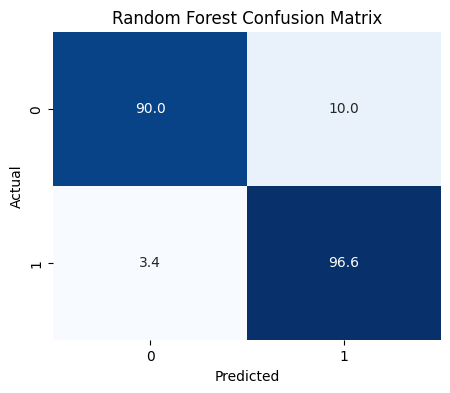

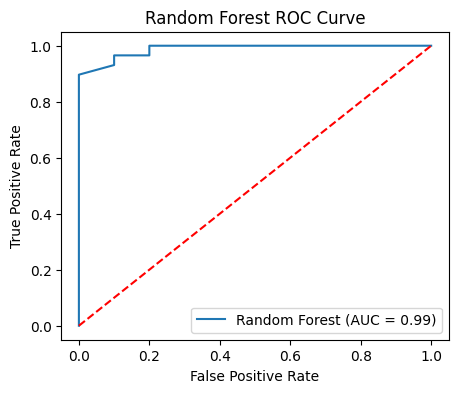

#############################################################################################
Performing RandomizedSearchCV for Decision Tree...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 6, 'min_samples_split': 13}

Decision Tree Model Evaluation Metrics:
Accuracy: 0.77
Precision: 0.88
Recall: 0.79
F1 Score: 0.84
ROC AUC: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.70      0.61        10
           1       0.88      0.79      0.84        29

    accuracy                           0.77        39
   macro avg       0.71      0.75      0.72        39
weighted avg       0.80      0.77      0.78        39



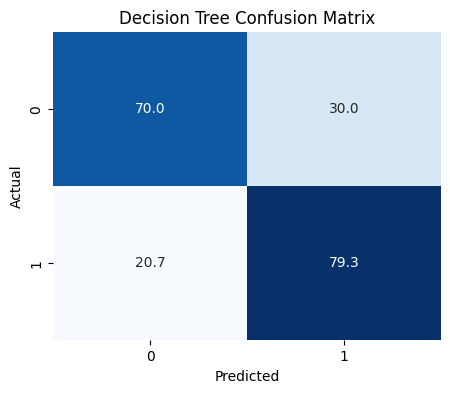

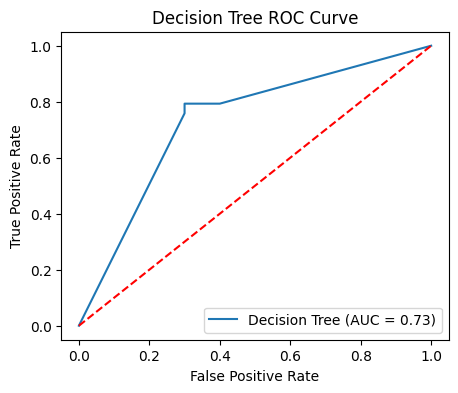

#############################################################################################
Performing RandomizedSearchCV for KSVM...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for KSVM: {'C': 9.3276479905464, 'gamma': 'scale', 'kernel': 'rbf'}

KSVM Model Evaluation Metrics:
Accuracy: 0.90
Precision: 0.96
Recall: 0.90
F1 Score: 0.93
ROC AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.96      0.90      0.93        29

    accuracy                           0.90        39
   macro avg       0.86      0.90      0.87        39
weighted avg       0.91      0.90      0.90        39



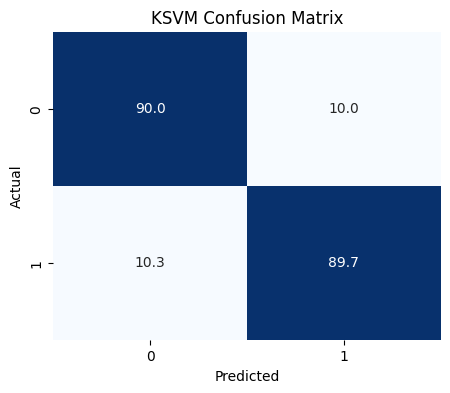

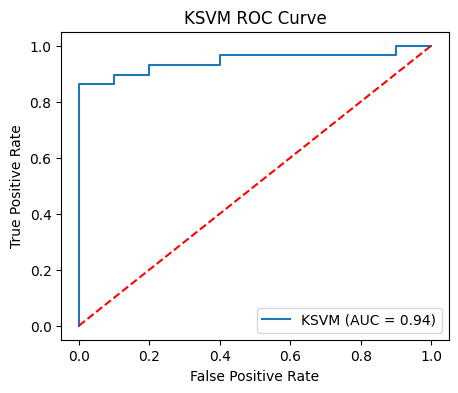

#############################################################################################
Performing RandomizedSearchCV for KNN...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

KNN Model Evaluation Metrics:
Accuracy: 0.87
Precision: 1.00
Recall: 0.83
F1 Score: 0.91
ROC AUC: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       1.00      0.83      0.91        29

    accuracy                           0.87        39
   macro avg       0.83      0.91      0.85        39
weighted avg       0.91      0.87      0.88        39



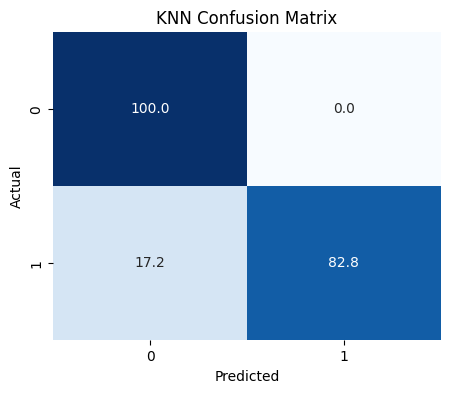

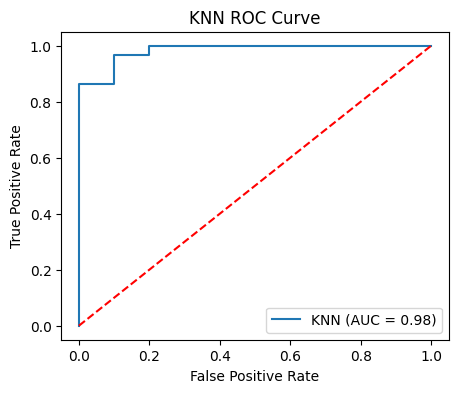

#############################################################################################


In [6]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_grids = {
    "Random Forest": {
        "n_estimators": randint(10, 300),
        "max_depth": randint(1, 50),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "bootstrap": [True, False],
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": randint(1, 50),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
    },
    "KSVM": {
        "C": uniform(0.1, 10),
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    "KNN": {
        "n_neighbors": randint(1, 50),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"],
    },
}

def evaluate_model_with_randomized_search(name, model, param_grid, X_train_scaled, X_test_scaled, y_train_resampled, y_test):
    print(f"Performing RandomizedSearchCV for {name}...")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=50, 
        scoring="roc_auc",  
        cv=5,  
        verbose=2,
        random_state=40,
        n_jobs=-1,
    )
    
    random_search.fit(X_train_scaled, y_train_resampled)
    
    best_model = random_search.best_estimator_
    print(f"Best Parameters for {name}: {random_search.best_params_}")

    predictions = best_model.predict(X_test_scaled)
    probabilities = best_model.predict_proba(X_test_scaled)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    # Store the results
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    # Display evaluation metrics
    print(f"\n{name} Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, predictions, normalize='true')
    sns.heatmap(cm * 100, annot=True, fmt=".1f", cmap="Blues", cbar=False)  # Convert to percentage
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
    print("#############################################################################################")

for name, model in models.items():
    param_grid = param_grids.get(name)
    if param_grid:
        evaluate_model_with_randomized_search(name, model, param_grid, X_train_scaled, X_test_scaled, y_train_resampled, y_test)
    else:
        print(f"No parameter grid defined for {name}, skipping RandomizedSearchCV.")


Starting RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters: {'batch_size': 23, 'epochs': 97, 'model__dropout_rate': 0.1979914312095726, 'model__l2_reg': 0.0055227288910538064, 'model__learning_rate': 0.0033533033076326435}

Tuned FNN Model Evaluation Metrics:
Accuracy: 0.95
Precision: 0.97
Recall: 0.97
F1 Score: 0.97
ROC AUC: 0.98


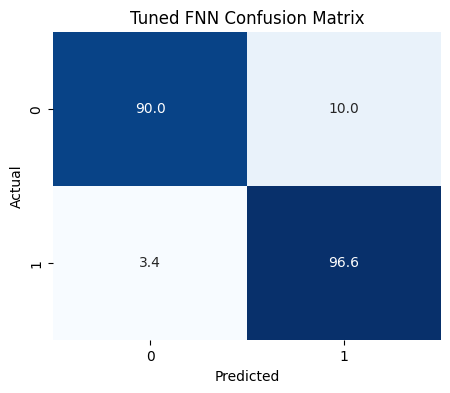

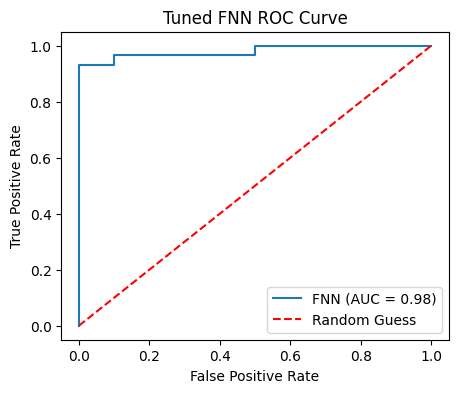

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier


def create_fnn(input_dim, dropout_rate=0.3, learning_rate=0.001, l2_reg=0.01):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim = X_train_scaled.shape[1]
fnn = KerasClassifier(
    model=create_fnn,
    input_dim=input_dim,
    epochs=50,
    batch_size=32,
    verbose=0, 
)


param_distributions = {
    "model__dropout_rate": uniform(0.1, 0.5),  
    "model__learning_rate": uniform(0.0001, 0.01),  
    "model__l2_reg": uniform(0.001, 0.1),  
    "batch_size": randint(16, 64),  
    "epochs": randint(20, 100),  
}


random_search = RandomizedSearchCV(
    estimator=fnn,
    param_distributions=param_distributions,
    n_iter=20, 
    scoring="roc_auc",
    cv=5,  
    verbose=2,
    random_state=42,
    n_jobs=-1,
)


print("Starting RandomizedSearchCV...")
random_search.fit(X_train_scaled, y_train_resampled)

best_fnn = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

y_pred_prob_fnn = best_fnn.predict_proba(X_test_scaled)[:, 1]
y_pred_fnn = (y_pred_prob_fnn > 0.5).astype(int)

# Calculate metrics
accuracy_fnn = accuracy_score(y_test, y_pred_fnn)
precision_fnn = precision_score(y_test, y_pred_fnn)
recall_fnn = recall_score(y_test, y_pred_fnn)
f1_fnn = f1_score(y_test, y_pred_fnn)
roc_auc_fnn = roc_auc_score(y_test, y_pred_prob_fnn)

model_results["Feed Neural Network"] = {
    'Accuracy': accuracy_fnn,
    'Precision': precision_fnn,
    'Recall': recall_fnn,
    'F1 Score': f1_fnn,
    'ROC AUC': roc_auc_fnn
}

# Print metrics
print("\nTuned FNN Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_fnn:.2f}")
print(f"Precision: {precision_fnn:.2f}")
print(f"Recall: {recall_fnn:.2f}")
print(f"F1 Score: {f1_fnn:.2f}")
print(f"ROC AUC: {roc_auc_fnn:.2f}")

# Confusion Matrix
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred_fnn, normalize='true')
sns.heatmap(cm * 100, annot=True, fmt=".1f", cmap="Blues", cbar=False)
plt.title("Tuned FNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_fnn)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"FNN (AUC = {roc_auc_fnn:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guess")
plt.title("Tuned FNN ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [8]:
performance_df = pd.DataFrame(model_results).T
print("\nModel Performance Comparison:\n")
print(performance_df)


Model Performance Comparison:

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Random Forest        0.948718   0.965517  0.965517  0.965517  0.987931
Decision Tree        0.769231   0.884615  0.793103  0.836364  0.731034
KSVM                 0.897436   0.962963  0.896552  0.928571  0.944828
KNN                  0.871795   1.000000  0.827586  0.905660  0.982759
Feed Neural Network  0.948718   0.965517  0.965517  0.965517  0.979310


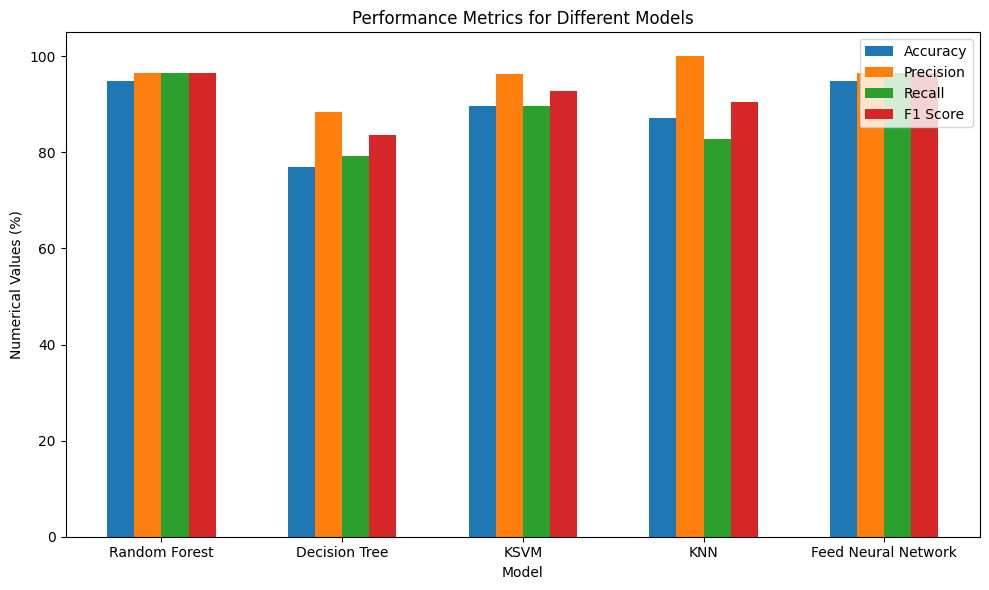

In [9]:
models = list(model_results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

values = {metric: [model_results[model][metric] * 100 for model in models] for metric in metrics}

x = np.arange(len(models))  
width = 0.15  

fig, ax = plt.subplots(figsize=(10, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, values[metric], width, label=metric)

ax.set_xlabel("Model")
ax.set_ylabel("Numerical Values (%)")
ax.set_title("Performance Metrics for Different Models")
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()